# Automatic Short Answer Scoring menggunakan Python 
Ada beberapa tahapan yang diperlukan dalam pengembangan sistem, yaitu:
1. Preparation
2. Pre-processing
3. Ekstraksi Fitur
4. Learning
5. Analisa Hasil

Pada experiment ini kita akan menggunakan dua dataset, Maccu Pichu dan Jaket

## 1. Preparation
Dalam tahap preparation, kita perlu mempersiapkan kamus *stopwords* terlebih dahulu.
* Stopwords merupakan kata-kata yang biasanya tidak signifikan secara makna (non-content words) (i.e. yang, dari, ke, dia, kamu, etc). Kita bisa juga menambahkan dalam list *stopwords* , kata-kata yang tidak baku (yg, karna). Stopwords di list dalam file **stopwords.txt**

Selain itu data essay (Maccu Pichu/Jaket) juga di-import terlebih dahulu.


In [36]:
import sys
import numpy as np
import csv
import pandas as pd

# maccu pichu dataset
filename = "/home/yunita/Data/Project/essay_scoring/Dataset/macu_picu/maccu-piccu_rescore.xlsx"
df = pd.read_excel(filename, sheetname='Sheet1', header=0)
df_ = df[df['rescore_original'] != 9]  # membuang row yang kosong
ans1 = np.array(df_['fte_data1'])
ans2 = np.array(df_['fte_data2'])
label = np.array(df_['rescore_ori'])

print filename
print len(ans1)
print len(ans2)
print set(label)

/home/yunita/Data/Project/essay_scoring/Dataset/macu_picu/maccu-piccu_rescore.xlsx
6618
6618
set([0, 1])


In [66]:
# jaket dataset
file_jaket = "/home/yunita/Data/Project/essay_scoring/Dataset/jaket/Skor_Jaket_Ulang.xlsx"
df_jaket = pd.read_excel(file_jaket, sheetname='Sheet1', header=0)
df_jaket_ = df_jaket[df_jaket['rescore'] != 9]  # membuang row yang kosong
answer_jaket = np.array(df_jaket_['fte_data_extract'])
label_jaket = np.array(df_jaket_['rescore'])

print file_jaket
print len(answer_jaket)
print set(label_jaket)

/home/yunita/Data/Project/essay_scoring/Dataset/jaket/Skor_Jaket_Ulang.xlsx
3043
set([0, 11, 12])


Memanggil kamus *stopwords* yang terdiri dari 766 kata. 

In [73]:
fstopw = open('/home/yunita/Data/Code/essay_scoring/stopwords.txt','r')
stopw = set([w for w in fstopw])
stopadd = ['karena','dia','adalah','jadi','yg','dan','ia','ini', 'di']
for s in stopadd:
  stopw.add(s)
print (len(stopw))

766


## 2. Pre-processing
Setelah data di-import dan kamus stopword sudah dipersiapkan, maka tahap berikutnya adalah melakukan pre-processing dengan membuang semua *stopwords* dan menyeragamkan jawaban dalam huruf kecil (*lowercasing*), untuk meminimalisir perbedaan penulisan jawaban.


In [74]:
# maccu pichu dataset
answer = []
for i in range(len(label)):
    ans = []
    if ans1[i] is np.nan:
        ans = ans2[i]
    elif ans2[i] is np.nan:
        ans = ans1[i]
    else:
        ans = ans1[i]+ans2[i]
    ans_lower = ans.lower()
    ans_stop = [word for word in ans_lower.split() if word not in stopw]
    answer.append(' '.join(ans_stop))

In [75]:
# jaket dataset
answ_jaket = []
for i in range(len(label_jaket)):
    ans_jaket_lower = answer_jaket[i].lower()
    ans_jaket_stop = [word for word in ans_jaket_lower.split() if word not in stopw]
    answ_jaket.append(' '.join(ans_jaket_stop))

### Kata yang paling banyak ditemukan untuk masing-masing dataset
dengan menggunakan bar plot kita bisa melihat kata apa yang paling sering muncul pada masing-masing dataset.

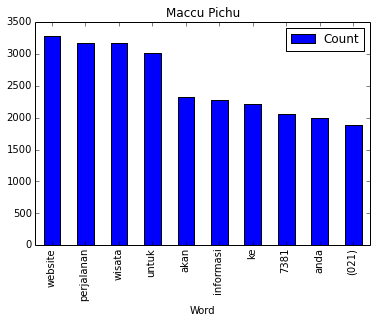

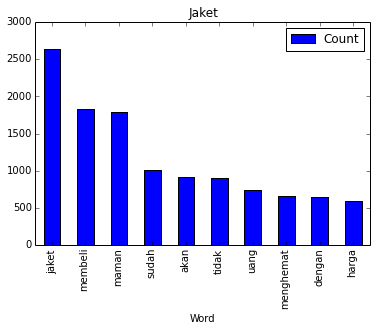

In [90]:
%matplotlib inline
import matplotlib
from collections import Counter
import matplotlib.pyplot as plt

#maccu pichu
word_list = " "
for ans in answer:
    word_list += ans
all_words = word_list.split(" ")
counts_words = Counter(all_words).most_common(10)
df_words = pd.DataFrame(counts_words, columns = ['Word', 'Count'])
df_words.plot(x='Word',y='Count', kind='bar', title='Maccu Pichu')

#jaket
word_list_jaket = " "
for ans in answ_jaket:
    word_list_jaket += ans
all_words_jaket = word_list_jaket.split(" ")
counts_words_jaket = Counter(all_words_jaket).most_common(10)
df_words_jaket = pd.DataFrame(counts_words_jaket, columns = ['Word', 'Count'])
df_words_jaket.plot(x='Word',y='Count', kind='bar', title='Jaket')

## 3. Ekstraksi Fitur
Tahap berikutnya adalah ekstraksi fitur. Untuk eksperimen kali ini, kita akan menggunakan frekuensi kata yang terdapat pada jawaban sebagai fitur. Untuk ekstraksi fitur, digunakan salah satu python library yang disebut Scikit Learn

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer="word", ngram_range=(1,1))
train_data = count_vect.fit_transform(answer)

In [53]:
train_data_jaket = count_vect.fit_transform(answ_jaket)

## 4. Learning
Tahap selanjutnya adalah learning dengan mengimplementasikan algoritma machine learning. Kita bisa mencoba beberapa algoritma dengan *cross-validation* untuk melihat algoritma mana yang paling optimal. Pada experiment dengan menggunakan 5-cross validation, dengan 4 metode yang berbeda, diperoleh akurasi tertinggi yaitu **97.23%** pada dataset Maccu Pichu dan **71.18%** pada dataset Jaket dengan menggunakan Ada Boost Classifier.

| Classifier        | Maccu Pichu           | Jaket  |
| ------------- |:-------------:| :-----:|
| Naive Bayes      | 94.68% | 62.40% |
| SVM      | 95.30%      |   64.73% |
| Random Forest | 61.96%      |    58.10% |
| AdaBoost | **97.23%**      |    **71.18%** |


In [54]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

clf1 = MultinomialNB()
clf2 = svm.SVC(probability=True, random_state=0)
clf3 = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
clf4 = AdaBoostClassifier()

print ("Naive Bayes:", np.mean(cross_val_score(clf1, train_data, label, scoring='accuracy',cv=5))) 
print ("SVM:", np.mean(cross_val_score(clf2, train_data, label, scoring='accuracy',cv=5))) 
print ("Random Forest:", np.mean(cross_val_score(clf3, train_data, label, scoring='accuracy',cv=5))) 
print ("Ada Boost:", np.mean(cross_val_score(clf4, train_data, label, scoring='accuracy',cv=5))) 

('Naive Bayes:', 0.9468109986867814)
('SVM:', 0.9530045832744669)
('Random Forest:', 0.6196752814130522)
('Ada Boost:', 0.9723462144565719)


In [55]:
print ("Naive Bayes:", np.mean(cross_val_score(clf1, train_data_jaket, label_jaket, scoring='accuracy',cv=5))) 
print ("SVM:", np.mean(cross_val_score(clf2, train_data_jaket, label_jaket, scoring='accuracy',cv=5))) 
print ("Random Forest:", np.mean(cross_val_score(clf3, train_data_jaket, label_jaket, scoring='accuracy',cv=5))) 
print ("Ada Boost:", np.mean(cross_val_score(clf4, train_data_jaket, label_jaket, scoring='accuracy',cv=5))) 

('Naive Bayes:', 0.624042562603431)
('SVM:', 0.6473827567842573)
('Random Forest:', 0.5810060300281614)
('Ada Boost:', 0.7118344054026429)


### Efek menggunakan fitur yang berbeda
Jika pada experiment yang pertama, kita menggunakan frekuensi kata sebagai fitur, maka kali ini kita akan mencoba menggunakan fitur yang berbeda. Fitur yang akan kita gunakan adalah frekuensi dari *character tri-grams*. Dengan menggunakan fitur character tri-grams diperoleh akurasi yang lebih baik terutama pada dataset Maccu Pichu. Akurasi terbaik diperoleh dengan AdaBoost classifier dengan **97.79%** untuk Maccu Pichu dan **71.27%** untuk Jaket.

| Classifier        | Maccu Pichu           | Jaket  |
| ------------- |:-------------:| :-----:|
| Naive Bayes      | 96.19% | 59.94% |
| SVM      | 97.00%      |   70.88% |
| Random Forest | 71.09%      |    58.10% |
| AdaBoost | **97.79%**      |    **71.27%** |


In [57]:
count_vect_trigram = CountVectorizer(analyzer="char", ngram_range=(3,3))
train_data_trigram = count_vect_trigram.fit_transform(answer)
train_data_jaket_trigram = count_vect_trigram.fit_transform(answ_jaket)

In [91]:
print "Maccu Pichu"
print "--------------------"
print ("Naive Bayes:", np.mean(cross_val_score(clf1, train_data_trigram, label, scoring='accuracy',cv=5))) 
print ("SVM:", np.mean(cross_val_score(clf2, train_data_trigram, label, scoring='accuracy',cv=5))) 
print ("Random Forest:", np.mean(cross_val_score(clf3, train_data_trigram, label, scoring='accuracy',cv=5))) 
print ("Ada Boost:", np.mean(cross_val_score(clf4, train_data_trigram, label, scoring='accuracy',cv=5))) 

print " --------------------"
print "Jaket"
print "--------------------"
print ("Naive Bayes:", np.mean(cross_val_score(clf1, train_data_jaket_trigram, label_jaket, scoring='accuracy',cv=5))) 
print ("SVM:", np.mean(cross_val_score(clf2, train_data_jaket_trigram, label_jaket, scoring='accuracy',cv=5))) 
print ("Random Forest:", np.mean(cross_val_score(clf3, train_data_jaket_trigram, label_jaket, scoring='accuracy',cv=5))) 
print ("Ada Boost:", np.mean(cross_val_score(clf4, train_data_jaket_trigram, label_jaket, scoring='accuracy',cv=5))) 

Maccu Pichu
--------------------
('Naive Bayes:', 0.9619195983142858)
('SVM:', 0.9700790976444921)
('Random Forest:', 0.7109720748788346)
('Ada Boost:', 0.9779377376112744)
 --------------------
Jaket
--------------------
('Naive Bayes:', 0.5994195579902725)
('SVM:', 0.7088274300809723)
('Random Forest:', 0.5810060300281614)
('Ada Boost:', 0.7127980390136466)


### Efek training size yang berbeda
Kita juga ingin melihat bagaimana jika data training yang tersedia hanya sedikit. Kita bisa mensimulasikan dengan mengambil sekitar proporsi yang berbeda dari data sebagai data training dan selebihnya sebagai data test. Secara umum, akurasi masih baik (dengan sedikit penurunan) meskipun training size yang digunakan kecil.

| Training portion | Maccu Pichu   | Jaket  |
| :-------------: |:-------------:| :-----:|
| 0.9           | 97.73%        | 75.73% |
| 0.8           | 97.80%        | 73.89% |
| 0.7           | 97.98%        |    73.49% |
| 0.6           | 97.88%         | 70.60%   |
| 0.5           | 98.03%         | 72.07%    |
| 0.4           | 98.13%         | 69.98%    |
| 0.3           | 98.01%         | 69.21%   |
| 0.2           | 97.96%         | 68.74%    |
| 0.1           | 97.61%         | 65.20%    |


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
np.random.seed(1337)

training_size = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
print "Maccu Pichu"
print "---------------------------------"
for k in training_size:
    X_train, X_test, y_train, y_test = train_test_split(train_data, label, train_size=k, random_state=42, shuffle=True)
    clf4.fit(X_train, y_train)
    y_pred = clf4.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print 'train_size:', k, 'akurasi:', acc

print "----------------------------------"
print "Jaket"
print "----------------------------------"
for k in training_size:
    X_train_jaket, X_test_jaket, y_train_jaket, y_test_jaket = train_test_split(train_data_jaket, label_jaket, train_size=k, random_state=42, shuffle=True)
    clf4.fit(X_train_jaket, y_train_jaket)
    y_pred_jaket = clf4.predict(X_test_jaket)
    acc_jaket = accuracy_score(y_test_jaket, y_pred_jaket)
    print 'train_size:', k, 'akurasi:', acc_jaket


Maccu Pichu
---------------------------------
train_size: 0.9 akurasi: 0.9773413897280967
train_size: 0.8 akurasi: 0.9780966767371602
train_size: 0.7 akurasi: 0.9798590130916415
train_size: 0.6 akurasi: 0.9788519637462235
train_size: 0.5 akurasi: 0.9803566032033847
train_size: 0.4 akurasi: 0.9813648954923193
train_size: 0.3 akurasi: 0.9801424562918195
train_size: 0.2 akurasi: 0.9796033994334278
train_size: 0.1 akurasi: 0.9761624979016283
----------------------------------
Jaket
----------------------------------
train_size: 0.9 akurasi: 0.7573770491803279
train_size: 0.8 akurasi: 0.7389162561576355
train_size: 0.7 akurasi: 0.7349397590361446
train_size: 0.6 akurasi: 0.7060755336617406
train_size: 0.5 akurasi: 0.7207621550591328
train_size: 0.4 akurasi: 0.6998904709748083
train_size: 0.3 akurasi: 0.6921633036133271
train_size: 0.2 akurasi: 0.6874743326488706
train_size: 0.1 akurasi: 0.6520627966411099


## 5. Analisa Hasil
Kita bisa menganalisa hasil klasifikasi dengan menggunakan confusion matriks. Kita akan mencoba menganalisa hasil klasifikasi pada dataset Jaket. Dari confusion matriks bisa diketahui bahwa, sistem masih banyak keliru dalam memprediksi kelas 11 dan 12. Bisa dikarenakan karena jumlah sampel yang tidak *balance* untuk setiap kelas.

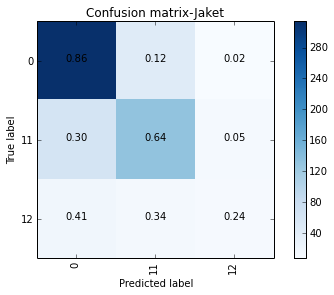

In [95]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    #print(cm)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
X_train_jaket, X_test_jaket, y_train_jaket, y_test_jaket = train_test_split(train_data_jaket, label_jaket, train_size=0.8, random_state=42, shuffle=True)
clf4.fit(X_train_jaket, y_train_jaket)
y_pred_jaket = clf4.predict(X_test_jaket)
cnf_matrix = confusion_matrix(y_test_jaket, y_pred_jaket)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=sorted(list(set(y_test_jaket))), normalize=True, title='Confusion matrix-Jaket')
plt.show()